In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, dopioe, unit_det

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None


In [11]:
def find_root(x, y):
    coeffs = np.polyfit(x, y, 3)
    roots = np.roots(np.poly1d(coeffs))
    real_roots = roots[np.isreal(roots)].real
    mid = x[len(x)//2]
    return real_roots[np.argmin(np.abs(mid - real_roots))]

def tang_at_root(x, y, rx):
    coeffs = np.polyfit(x, y, 3)
    deriv = np.polyder(coeffs)
    slope = np.polyval(deriv, rx)
    intercept = np.polyval(coeffs, rx) - slope * rx
    return slope, intercept
    

In [12]:
width=500
x = np.linspace(-width // 2, width // 2, 101)
y = np.linspace(-width // 2, width // 2, 101)
X, Y = np.meshgrid(x, y, indexing='ij')

xc, yc = 0.0, 0.0
Q11, Q12, Q22 = 1, .4, 1
psi0 = 250.0
Rc = 85.0
A = - psi0 / Rc**2

# rescale Q to have unit determinant
Q, _ = unit_det(Q=np.array([[Q11, Q12], [Q12, Q22]]))
q11, q12, q22 = Q[0,0], Q[0,1], Q[1,1]

df_res = pd.DataFrame({'xc': [xc], 'yc': [yc], 'w': [2*A*(q11+q22)*1e-3], 'q11': [q11], 'q12': [q12], 'q22': [q22],
                        'Rc': [Rc], 'psi0': [psi0], 'A': [A]})

dx, dy = X - xc, Y - yc
rho2 = q11*dx**2 + 2*q12*dx*dy + q22*dy**2
Qr2 = (q11*dx + q12*dy)**2 + (q12*dx + q22*dy)**2 # ||Qr||
psi = psi0 * np.exp( - rho2 / Rc**2 )
u =   psi0 * np.exp( - rho2 / Rc**2 ) * ( 2*q12*dx + 2*q22*dy ) / Rc**2
v = - psi0 * np.exp( - rho2 / Rc**2 ) * ( 2*q11*dx + 2*q12*dy ) / Rc**2

df_res


,xc,yc,w,q11,q12,q22,Rc,psi0,A
0,0.0,0.0,-0.000151,1.091089,0.436436,1.091089,85.0,250.0,-0.034602


,xc,yc,w,q11,q12,q22,Rc,psi0,A
Control,0.000000,0.000000,-0.000151,1.091089,0.436436,1.091089,85.000000,250.000000,-0.034602
P1,-0.167131,-0.167131,-0.000144,1.089919,0.433501,1.089919,85.649101,252.264075,-0.034388
P2,0.946608,-0.946608,-0.000132,1.094395,0.444635,1.094395,86.805676,256.060854,-0.033982
P3,-5.285182,-5.285182,-0.000166,1.088537,0.430014,1.088537,73.002764,223.607889,-0.041957
L1,-0.061639,-0.061639,-0.000147,1.091196,0.436702,1.091196,85.444923,251.494911,-0.034447
L2,-0.167131,-0.167131,-0.000144,1.089919,0.433501,1.089919,85.649101,252.264075,-0.034388
L3,-0.248601,-0.248601,-0.000141,1.088311,0.429444,1.088311,85.571920,252.306600,-0.034456


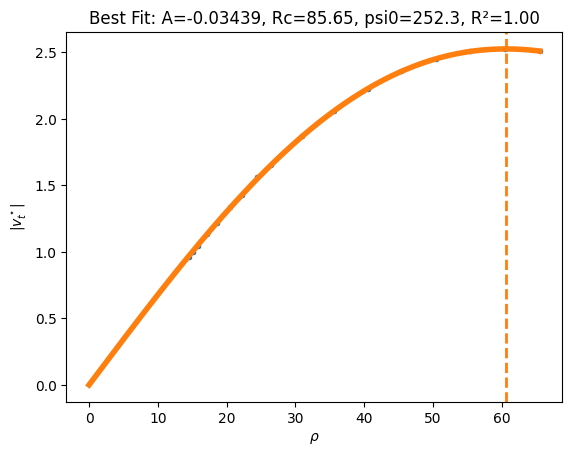

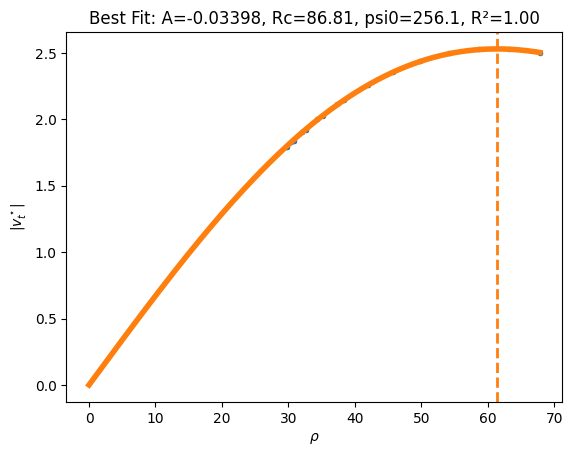

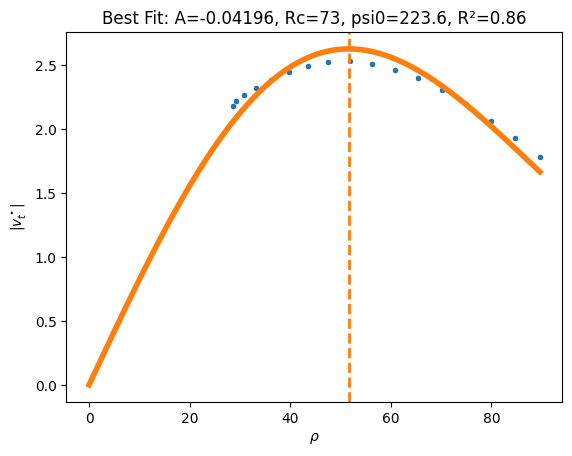

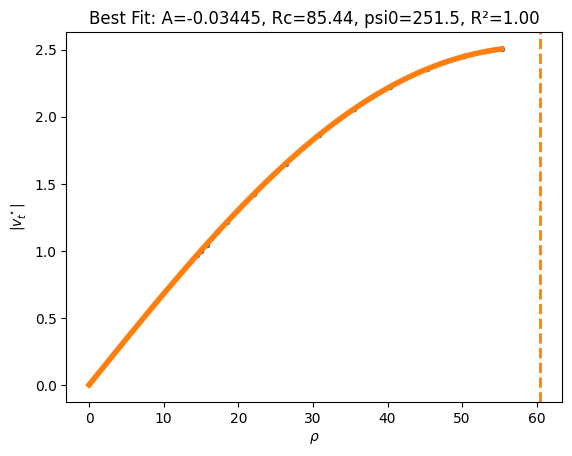

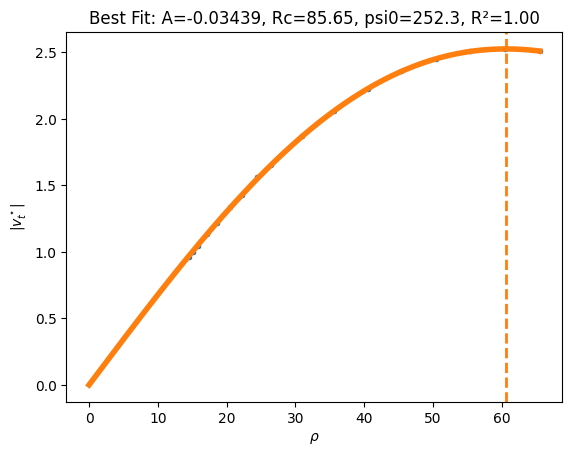

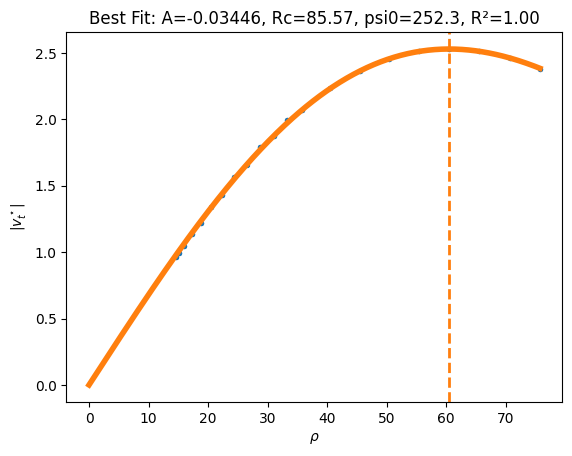

In [13]:
nic, njc = 53, 53
r = 8

df_tests = pd.DataFrame({
    'nic': [nic, 44, 43, nic, nic, nic],
    'njc': [njc, 56, 43, njc, njc, njc],
    'r': [r, r, r, r-2, r, r+2]
}, index=['P1', 'P2', 'P3', 'L1', 'L2', 'L3'])


dic_tests = {}
for test in df_tests.index:
    data = df_tests.loc[test]

    x1 = x[data.nic-data.r:data.nic+data.r+1]
    y1 = np.array([y[data.njc]] * len(x1))

    u1 = u[data.nic-data.r:data.nic+data.r+1, data.njc]
    v1 = v[data.nic-data.r:data.nic+data.r+1, data.njc]

    y2 = y[data.njc-data.r:data.njc+data.r+1]
    x2 = np.array([x[data.nic]] * len(y2))

    u2 = u[data.nic, data.njc-data.r:data.njc+data.r+1]
    v2 = v[data.nic, data.njc-data.r:data.njc+data.r+1]

    points1 = set(zip(x1, y1)); points2 = set(zip(x2, y2))
    common_points = points1 & points2
    # Remove duplicates from (x1, y1, u1, v1)
    mask = ~np.array([(x, y) in common_points for x, y in zip(x1, y1)])
    x1f = x1[mask]; y1f = y1[mask]; u1f = u1[mask]; v1f = v1[mask]
    # Concatenate with unaltered second set
    xi = np.concatenate([x1f, x2]); yi = np.concatenate([y1f, y2])
    ui = np.concatenate([u1f, u2]); vi = np.concatenate([v1f, v2])

    xc_dop, yc_dop, w_dop, Q_dop, Rc_dop, psi0_dop, A_dop = dopioe(x1, y1, u1, v1, x2, y2, u2, v2, plot_flag=True)
    w_dop *= 1e-3
    
    dic_tests[test] = {'x1': x1, 'y1': y1, 'u1': u1, 'v1': v1,
                       'x2': x2, 'y2': y2, 'u2': u2, 'v2': v2,
                       'name': test}
    df_res.loc[len(df_res)] = {'xc': xc_dop, 'yc': yc_dop, 'w': w_dop,
                               'q11': Q_dop[0,0], 'q12': Q_dop[0,1], 'q22': Q_dop[1,1],
                               'Rc': Rc_dop, 'psi0': psi0_dop, 'A': A_dop}
                            
df_res.index = ['Control'] +  list(df_tests.index)
df_res


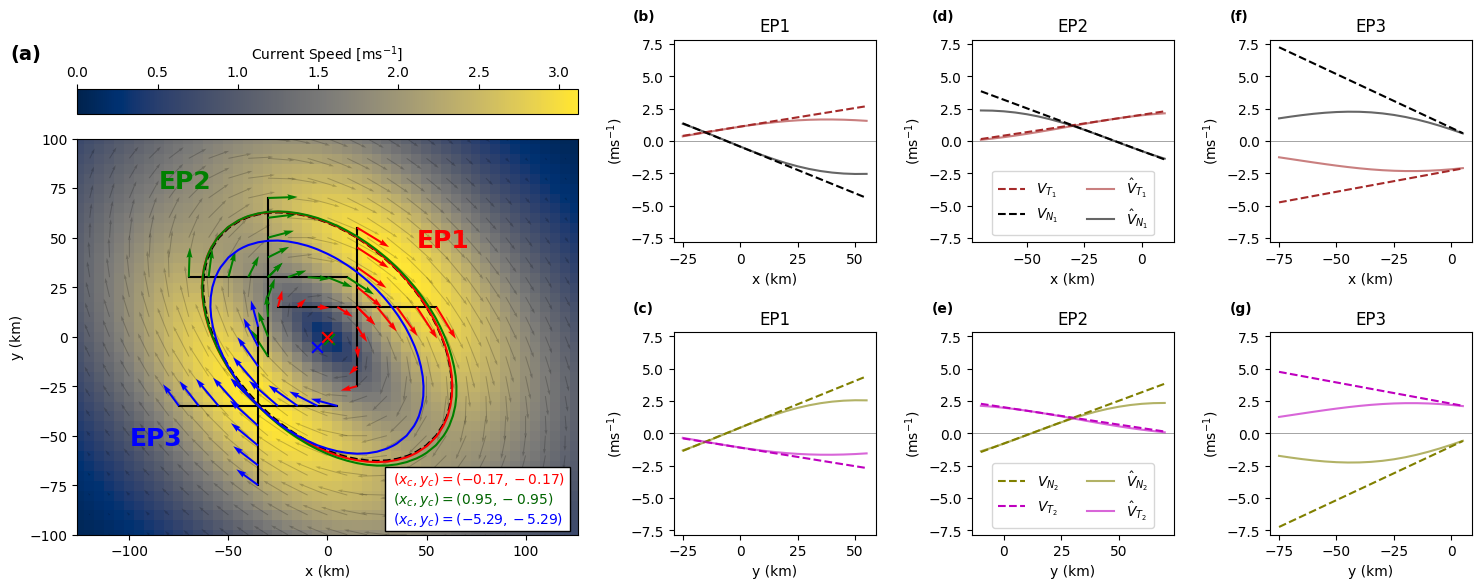

In [14]:
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(15, 6))

gs = gridspec.GridSpec(2, 5, figure=fig)
ax_main = fig.add_subplot(gs[:2, :2])
cmap = 'cividis'
spacing, scale, width = 2, 40, 0.002 #0.004
pc = ax_main.pcolor(x, y, np.hypot(u, v).T, cmap=cmap)
plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='Current Speed [ms$^{-1}$]')
ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, 
               alpha=0.2, scale=scale, width=width)

ax_main.contour(X, Y, rho2, levels=[Rc**2/2],
                     colors='k', linestyles='--')

# colours = ['r', 'darkgreen', 'b']
colours = ['r', 'g', 'b'] # limegreen
color = ['r', 'g', 'b']

i = 0
scales = [40, 58, 65]
for dic in dic_tests.values():
    if 'P' in dic['name']:

        x1, y1, u1, v1, x2, y2, u2, v2 = (dic[k] for k in ['x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2'])
        data = df_res.loc[dic['name']]
 
        ax_main.plot(x1, y1, 'k', zorder=1)
        ax_main.plot(x2, y2, 'k', zorder=1)

        ax_main.quiver(x1[::spacing], y1[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width*2, color=colours[i])
        ax_main.quiver(x2[::spacing], y2[::spacing], u2[::spacing], v2[::spacing], scale=scale, width=width*2, color=colours[i])
        ax_main.scatter(data.xc, data.yc, marker='x', s=60, color=colours[i], zorder=10-extract_number(dic['name']))

        dx_ell, dy_ell = X - data.xc, Y - data.yc
        rho2_ell = data.q11*dx_ell**2 + 2*data.q12*dx_ell*dy_ell + data.q22*dy_ell**2
        ax_main.contour(X, Y, rho2_ell, levels=[data.Rc**2/2], colors=colours[i])


        ax_main.text(33, -74 - 10*i, fr'$(x_c,y_c)=({data.xc:.2f},{data.yc:.2f})$', color='darkgreen' if '2' in dic['name'] else colours[i], zorder=11)
        i += 1

x_pos, y_pos = 0.80, 0.09
box_width = 0.37  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main.transAxes,
                       facecolor='white', edgecolor='black', zorder=10)
ax_main.add_patch(rect)
        
ax_main.text(-160, 140, '(a)', fontsize=14, fontweight='bold')  # Adjust coordinates as needed
ax_main.axis('equal')
ax_main.set_xlim(-100, 100)
ax_main.set_ylim(-100, 100)
ax_main.set_xlabel('x (km)')
ax_main.set_ylabel('y (km)')

axs = []
j = 2 
i = 0
tags = [('(b)','(c)', 'EP1'), ('(f)','(g)', 'EP3'), ('(d)','(e)', 'EP2')]
for dic in dic_tests.values():
    if 'P' in dic['name']:

        x1, y1, u1, v1, x2, y2, u2, v2 = (dic[k] for k in ['x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2'])
        data = df_res.loc[dic['name']]
        ax2 = fig.add_subplot(gs[0, j])
        ax3 = fig.add_subplot(gs[1, j])
    
        root_x = find_root(x1, v1)
        A1, A0 = tang_at_root(x1, u1, root_x)
        B1, B0 = tang_at_root(x1, v1, root_x)
        p_u1 = A1*x1 + A0
        p_v1 = B1*x1 + B0

        root_y = find_root(y2, u2)
        C1, C0 = tang_at_root(y2, u2, root_y)
        D1, D0 = tang_at_root(y2, v2, root_y)
        p_u2 = C1*y2 + C0
        p_v2 = D1*y2 + D0
    
        ax2.plot(x1, p_u1, linestyle='--', color='brown', label=r'$V_{T_1}$')
        ax2.plot(x1, p_v1, 'k--', label=r'$V_{N_1}$')
        ax2.plot(x1, u1, color='brown', label=r'$\hat{V}_{T_1}$', alpha=.6)#, color=colours[i])
        ax2.plot(x1, v1, 'k', label=r'$\hat{V}_{N_1}$', alpha=.6)#, color=colours[i+1])
        ax2.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax2.set_ylabel('(ms$^{-1}$)')
        ax2.set_xlabel(r'x (km)')
        if '2' in dic['name']:
            ax2.legend(loc='lower center', ncol=2)
        ax2.set_title(tags[2-j][2])
        ax2.text(-0.2, 1.15, tags[2-j][0], transform=ax2.transAxes, fontsize=10, fontweight='bold', va='top', ha='left')#, color=colours[i])
        
        ax3.plot(y2, p_u2, linestyle='--', color='olive', label=r'$V_{N_2}$')
        ax3.plot(y2, p_v2, 'm--', label=r'$V_{T_2}$')
        ax3.plot(y2, u2, color='olive', label=r'$\hat{V}_{N_2}$', alpha=.6)#, color=colours[i])
        ax3.plot(y2, v2, 'm', label=r'$\hat{V}_{T_2}$', alpha=.6)#, color=colours[i+1])
        ax3.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax3.set_ylabel('(ms$^{-1}$)')
        ax3.set_xlabel(r'y (km)')
        if '2' in dic['name']:
            ax3.legend(loc='lower center', ncol=2)
        ax3.set_title(tags[2-j][2])
        ax3.text(-0.2, 1.15, tags[2-j][1], transform=ax3.transAxes, fontsize=10, fontweight='bold', va='top', ha='left')#, color=colours[i])

        axs.extend([ax2, ax3])
        j += 1
        i += 1
        
ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

ax_main.text(45, 45, 'EP1', color=color[0], zorder=3, fontsize=18, fontweight='bold')
ax_main.text(-85, 75, 'EP2', color=color[1], zorder=3, fontsize=18, fontweight='bold')
ax_main.text(-100, -55, 'EP3', color=color[2], zorder=3, fontsize=18, fontweight='bold')

plt.tight_layout()
plt.show()


In [15]:
df_res


,xc,yc,w,q11,q12,q22,Rc,psi0,A
Control,0.000000,0.000000,-0.000151,1.091089,0.436436,1.091089,85.000000,250.000000,-0.034602
P1,-0.167131,-0.167131,-0.000144,1.089919,0.433501,1.089919,85.649101,252.264075,-0.034388
P2,0.946608,-0.946608,-0.000132,1.094395,0.444635,1.094395,86.805676,256.060854,-0.033982
P3,-5.285182,-5.285182,-0.000166,1.088537,0.430014,1.088537,73.002764,223.607889,-0.041957
L1,-0.061639,-0.061639,-0.000147,1.091196,0.436702,1.091196,85.444923,251.494911,-0.034447
L2,-0.167131,-0.167131,-0.000144,1.089919,0.433501,1.089919,85.649101,252.264075,-0.034388
L3,-0.248601,-0.248601,-0.000141,1.088311,0.429444,1.088311,85.571920,252.306600,-0.034456


### Pres Plots

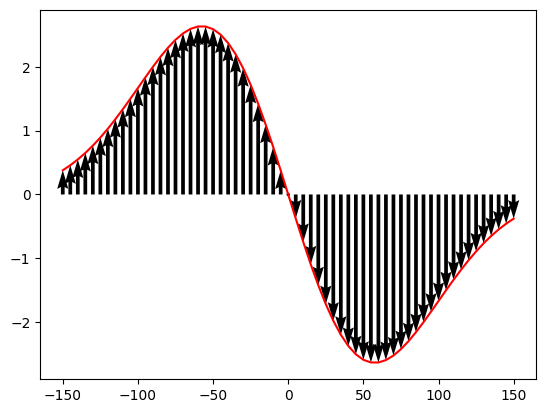

In [16]:
data = pd.DataFrame({'nic': [50], 'njc': [50], 'r': [30]}).iloc[0]

x1 = x[data.nic-data.r:data.nic+data.r+1]
y1 = np.array([y[data.njc]] * len(x1))

u1 = u[data.nic-data.r:data.nic+data.r+1, data.njc]
v1 = v[data.nic-data.r:data.nic+data.r+1, data.njc]


plt.quiver(x1, [0]*len(x1), [0]*len(v1), v1, scale_units='xy', scale=1)
plt.plot(x1, v1, color='r') 



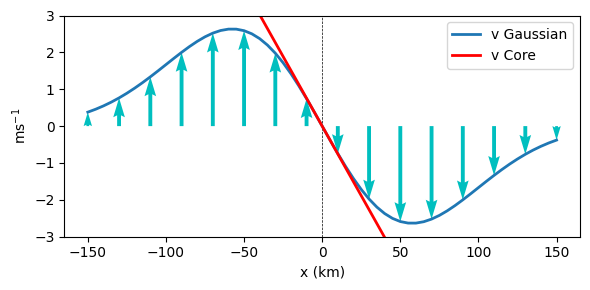

In [17]:
plt.figure(figsize=(6,3))
plt.axvline(x=0, color='k', linewidth=.5, linestyle='--')
plt.plot(x1, v1, linewidth=2, label='v Gaussian')
spac = 4
plt.quiver(x1[::spac], [0]*len(x1[::spac]), [0]*len(v1[::spac]), v1[::spac], scale_units='xy', scale=1, color='c')

vcore = 2*A*q11*(x1-xc) + 2*A*q12*(y1-yc)
plt.plot(x1, vcore, 'r-', linewidth=2, label='v Core')

plt.legend()
plt.xlabel(r'x (km)')
plt.ylabel(r'ms$^{-1}$')
plt.ylim(-3, 3)
plt.tight_layout()


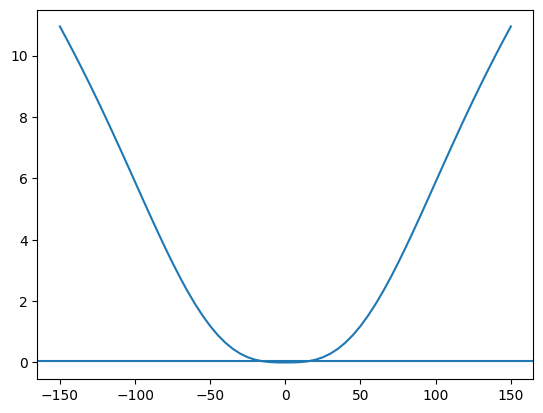

In [18]:
plt.plot(x1, np.abs(vcore-v1))
plt.axhline(y=.05)